#Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

#Data Wrangling

In [33]:
# Load the dataset

df = pd.read_csv('/content/drive/My Drive/Project 1/heart_disease.csv')
df.head()

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


In [34]:
# Dataset info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9971 non-null   float64
 1   Gender                9981 non-null   object 
 2   Blood Pressure        9981 non-null   float64
 3   Cholesterol Level     9970 non-null   float64
 4   Exercise Habits       9975 non-null   object 
 5   Smoking               9975 non-null   object 
 6   Family Heart Disease  9979 non-null   object 
 7   Diabetes              9970 non-null   object 
 8   BMI                   9978 non-null   float64
 9   High Blood Pressure   9974 non-null   object 
 10  Low HDL Cholesterol   9975 non-null   object 
 11  High LDL Cholesterol  9974 non-null   object 
 12  Alcohol Consumption   7414 non-null   object 
 13  Stress Level          9978 non-null   object 
 14  Sleep Hours           9975 non-null   float64
 15  Sugar Consumption   

In [35]:
# Checking duplicate data in dataset

print("Total duplicated data in df:",df.duplicated().sum())

Total duplicated data in df: 0


In [36]:
# Checking missing value in dataset

print("Missing value in df:\n",df.isna().sum())

Missing value in df:
 Age                       29
Gender                    19
Blood Pressure            19
Cholesterol Level         30
Exercise Habits           25
Smoking                   25
Family Heart Disease      21
Diabetes                  30
BMI                       22
High Blood Pressure       26
Low HDL Cholesterol       25
High LDL Cholesterol      26
Alcohol Consumption     2586
Stress Level              22
Sleep Hours               25
Sugar Consumption         30
Triglyceride Level        26
Fasting Blood Sugar       22
CRP Level                 26
Homocysteine Level        20
Heart Disease Status       0
dtype: int64


## Filling The Missing Value (For Numeric Columns)

In [37]:
# Dataset description (general statistic for numeric columns)

df.describe()

,Age,Blood Pressure,Cholesterol Level,BMI,Sleep Hours,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
count,9971.000000,9981.000000,9970.000000,9978.000000,9975.000000,9974.000000,9978.000000,9974.000000,9980.000000
mean,49.296259,149.757740,225.425577,29.077269,6.991329,250.734409,120.142213,7.472201,12.456271
std,18.193970,17.572969,43.575809,6.307098,1.753195,87.067226,23.584011,4.340248,4.323426
min,18.000000,120.000000,150.000000,18.002837,4.000605,100.000000,80.000000,0.003647,5.000236
25%,34.000000,134.000000,187.000000,23.658075,5.449866,176.000000,99.000000,3.674126,8.723334
50%,49.000000,150.000000,226.000000,29.079492,7.003252,250.000000,120.000000,7.472164,12.409395
75%,65.000000,165.000000,263.000000,34.520015,8.531577,326.000000,141.000000,11.255592,16.140564
max,80.000000,180.000000,300.000000,39.996954,9.999952,400.000000,160.000000,14.997087,19.999037


In [38]:
num_columns = ['Age',	'Blood Pressure',	'Cholesterol Level',	'BMI',	'Sleep Hours',	'Triglyceride Level',	'Fasting Blood Sugar',	'CRP Level',	'Homocysteine Level']
for column in num_columns:
  # Menghitung IQR
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  # Menentukan batas outlier
  batas_bawah = Q1 - 1.5 * IQR
  batas_atas = Q3 + 1.5 * IQR

  # Mengidentifikasi outlier
  outliers = df[(df[column] < batas_bawah) | (df[column] > batas_atas)]
  print("Outlier dengan metode IQR pada kolom {}:".format(column))
  print(outliers)

Outlier dengan metode IQR pada kolom Age:
Empty DataFrame
Columns: [Age, Gender, Blood Pressure, Cholesterol Level, Exercise Habits, Smoking, Family Heart Disease, Diabetes, BMI, High Blood Pressure, Low HDL Cholesterol, High LDL Cholesterol, Alcohol Consumption, Stress Level, Sleep Hours, Sugar Consumption, Triglyceride Level, Fasting Blood Sugar, CRP Level, Homocysteine Level, Heart Disease Status]
Index: []

[0 rows x 21 columns]
Outlier dengan metode IQR pada kolom Blood Pressure:
Empty DataFrame
Columns: [Age, Gender, Blood Pressure, Cholesterol Level, Exercise Habits, Smoking, Family Heart Disease, Diabetes, BMI, High Blood Pressure, Low HDL Cholesterol, High LDL Cholesterol, Alcohol Consumption, Stress Level, Sleep Hours, Sugar Consumption, Triglyceride Level, Fasting Blood Sugar, CRP Level, Homocysteine Level, Heart Disease Status]
Index: []

[0 rows x 21 columns]
Outlier dengan metode IQR pada kolom Cholesterol Level:
Empty DataFrame
Columns: [Age, Gender, Blood Pressure, Chol

Banyak *missing value* pada masing-masing kolom relatif sedikit dibandingkan dengan total data yang ada (kurang lebih 0.2% - 0.3%). Ditambah dengan kondisi data yang aman dari *outlier*. Jadi bisa digunakan nilai rata-rata pada masing-masing kolom untuk mengisi *missing value*.

In [39]:
# fill the missing value of each columny with the mean of it

num_columns = ['Age',	'Blood Pressure',	'Cholesterol Level',	'BMI',	'Sleep Hours',	'Triglyceride Level',	'Fasting Blood Sugar',	'CRP Level',	'Homocysteine Level']
for column in num_columns:
  df[column]=df[column].fillna(df[column].mean())

## Filling The Missing Value (For Categoric Columns)

In [40]:
# Checking missing value in dataset

print("Missing value in df:\n",df.isna().sum())

Missing value in df:
 Age                        0
Gender                    19
Blood Pressure             0
Cholesterol Level          0
Exercise Habits           25
Smoking                   25
Family Heart Disease      21
Diabetes                  30
BMI                        0
High Blood Pressure       26
Low HDL Cholesterol       25
High LDL Cholesterol      26
Alcohol Consumption     2586
Stress Level              22
Sleep Hours                0
Sugar Consumption         30
Triglyceride Level         0
Fasting Blood Sugar        0
CRP Level                  0
Homocysteine Level         0
Heart Disease Status       0
dtype: int64


In [41]:
cat_columns = ['Gender',	'Exercise Habits',	'Smoking',	'Family Heart Disease',	'Diabetes', 'High Blood Pressure',	'Low HDL Cholesterol',	'High LDL Cholesterol',	'Alcohol Consumption',	'Stress Level',	'Sugar Consumption',	'Heart Disease Status']
for column in cat_columns:
  print("Value in {}:\n".format(column),df[column].value_counts())

Value in Gender:
 Gender
Male      5003
Female    4978
Name: count, dtype: int64
Value in Exercise Habits:
 Exercise Habits
High      3372
Medium    3332
Low       3271
Name: count, dtype: int64
Value in Smoking:
 Smoking
Yes    5123
No     4852
Name: count, dtype: int64
Value in Family Heart Disease:
 Family Heart Disease
No     5004
Yes    4975
Name: count, dtype: int64
Value in Diabetes:
 Diabetes
No     5018
Yes    4952
Name: count, dtype: int64
Value in High Blood Pressure:
 High Blood Pressure
Yes    5022
No     4952
Name: count, dtype: int64
Value in Low HDL Cholesterol:
 Low HDL Cholesterol
Yes    5000
No     4975
Name: count, dtype: int64
Value in High LDL Cholesterol:
 High LDL Cholesterol
No     5036
Yes    4938
Name: count, dtype: int64
Value in Alcohol Consumption:
 Alcohol Consumption
Medium    2500
Low       2488
High      2426
Name: count, dtype: int64
Value in Stress Level:
 Stress Level
Medium    3387
Low       3320
High      3271
Name: count, dtype: int64
Value in Su

In [42]:
# Fill the missing value in 'Alcohol Consumption' column with 'None'

df['Alcohol Consumption'] = df['Alcohol Consumption'].fillna('None')

In [43]:
# Fill the missing value in each categoric columns with the exist value randomly

import random
def fill_missing_randomly(df, column_name):
    """Mengisi missing values dalam kolom dengan nilai unik yang ada secara acak."""
    unique_values = df[column_name].dropna().unique()

    if len(unique_values) == 0: # Handle if no unique values other than NaN
        print(f"Kolom '{column_name}' kosong atau hanya berisi NaN. Tidak ada nilai unik untuk diisi.")
        return df

    if len(unique_values) == 1: # Handle if only one unique value
        print(f"Kolom '{column_name}' hanya memiliki satu nilai unik. Mengisi semua NaN dengan nilai tersebut.")
        df[column_name] = df[column_name].fillna(unique_values[0])
        return df

    df[column_name] = df[column_name].fillna(pd.Series(np.random.choice(unique_values, size=len(df)), index=df.index))
    return df

for column in cat_columns:
  df = fill_missing_randomly(df, column)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   10000 non-null  float64
 1   Gender                10000 non-null  object 
 2   Blood Pressure        10000 non-null  float64
 3   Cholesterol Level     10000 non-null  float64
 4   Exercise Habits       10000 non-null  object 
 5   Smoking               10000 non-null  object 
 6   Family Heart Disease  10000 non-null  object 
 7   Diabetes              10000 non-null  object 
 8   BMI                   10000 non-null  float64
 9   High Blood Pressure   10000 non-null  object 
 10  Low HDL Cholesterol   10000 non-null  object 
 11  High LDL Cholesterol  10000 non-null  object 
 12  Alcohol Consumption   10000 non-null  object 
 13  Stress Level          10000 non-null  object 
 14  Sleep Hours           10000 non-null  float64
 15  Sugar Consumption   

# EDA (Exploratory Data Analysis)

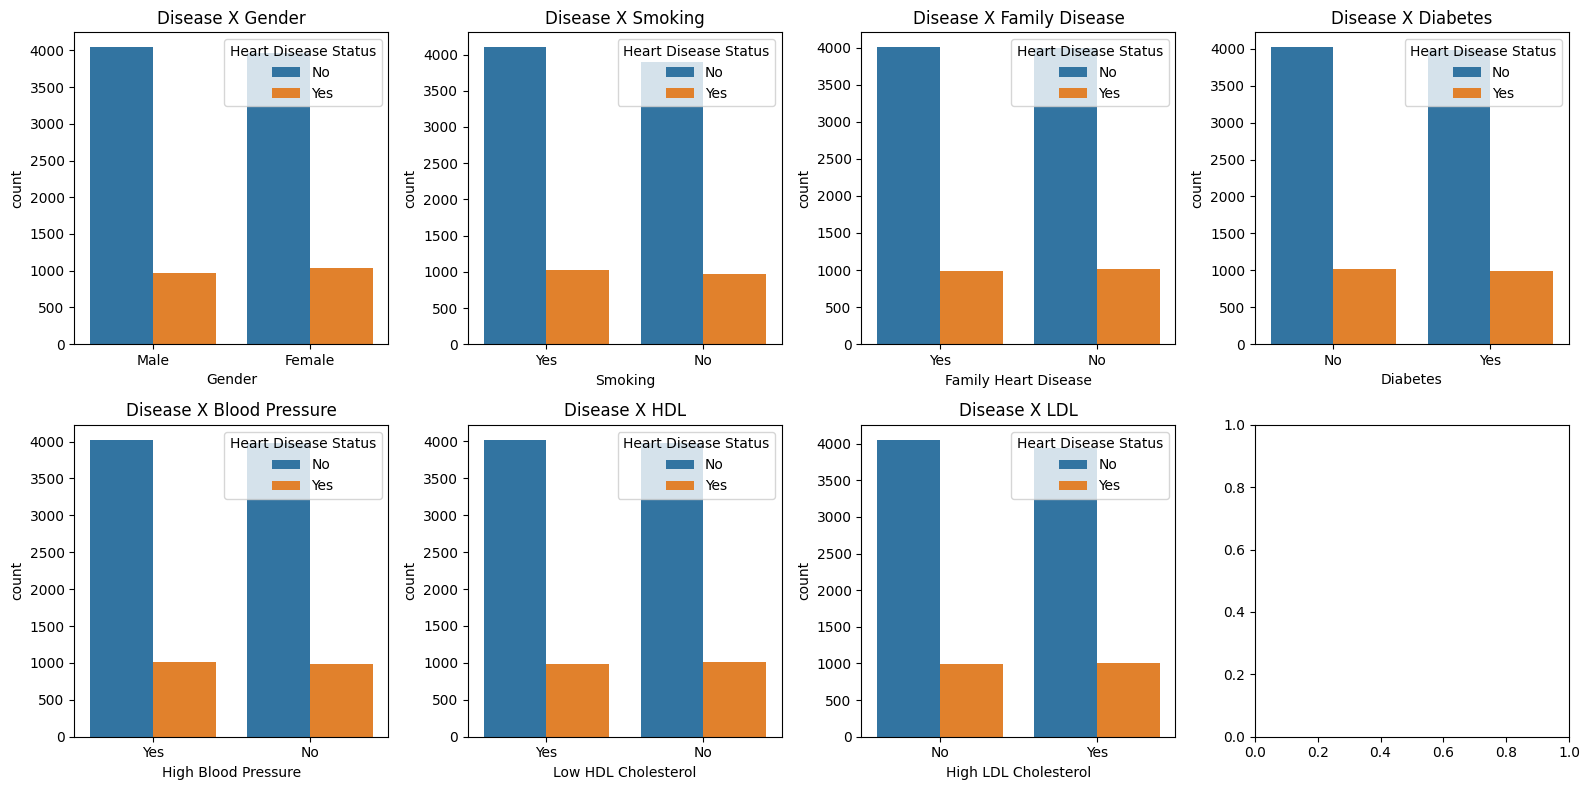

In [45]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 baris, 2 kolom subplot

# Visualisasi 1: Gender
sns.countplot(x='Gender', hue='Heart Disease Status', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Disease X Gender')

# Visualisasi 2: Status Merokok
sns.countplot(x='Smoking', hue='Heart Disease Status', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Disease X Smoking')

# Visualisasi 3: Status Diabetes
sns.countplot(x='Family Heart Disease', hue='Heart Disease Status', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Disease X Family Disease')

# Visualisasi 3: Status Diabetes
sns.countplot(x='Diabetes', hue='Heart Disease Status', data=df, ax=axes[0, 3])
axes[0, 3].set_title('Disease X Diabetes')

# Visualisasi 1: Gender
sns.countplot(x='High Blood Pressure', hue='Heart Disease Status', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Disease X Blood Pressure')

# Visualisasi 2: Status Merokok
sns.countplot(x='Low HDL Cholesterol', hue='Heart Disease Status', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Disease X HDL')

# Visualisasi 3: Status Diabetes
sns.countplot(x='High LDL Cholesterol', hue='Heart Disease Status', data=df, ax=axes[1, 2])
axes[1, 2].set_title('Disease X LDL')

plt.tight_layout()  # Untuk mencegah tumpang tindih antar subplot
plt.show()

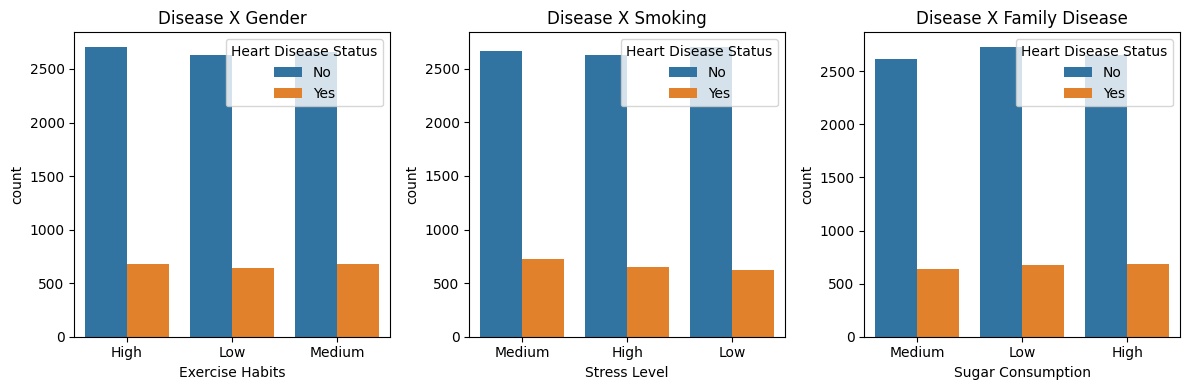

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 2 baris, 2 kolom subplot

# Visualisasi 1: Gender
sns.countplot(x='Exercise Habits', hue='Heart Disease Status', data=df, ax=axes[0])
axes[0].set_title('Disease X Gender')

# Visualisasi 2: Status Merokok
sns.countplot(x='Stress Level', hue='Heart Disease Status', data=df, ax=axes[1])
axes[1].set_title('Disease X Smoking')

# Visualisasi 3: Status Diabetes
sns.countplot(x='Sugar Consumption', hue='Heart Disease Status', data=df, ax=axes[2])
axes[2].set_title('Disease X Family Disease')

plt.tight_layout()  # Untuk mencegah tumpang tindih antar subplot
plt.show()

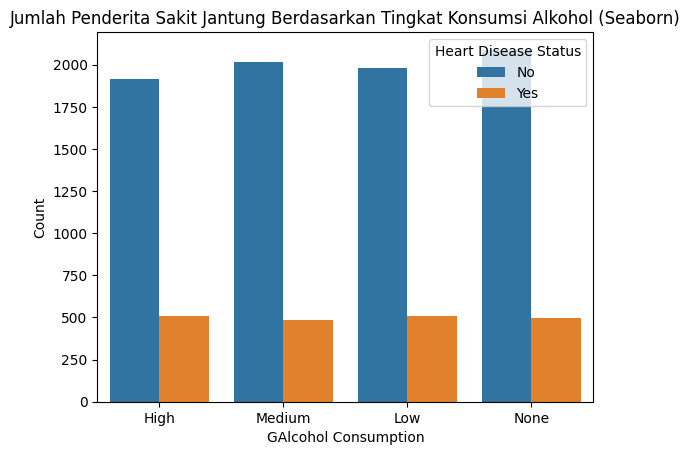

In [47]:
sns.countplot(x='Alcohol Consumption', hue='Heart Disease Status', data=df)
plt.title('Jumlah Penderita Sakit Jantung Berdasarkan Tingkat Konsumsi Alkohol (Seaborn)')
plt.xlabel('GAlcohol Consumption')
plt.ylabel('Count')
plt.show()

In [48]:
# One-hot encoding for all of the categorical columns

cat_columns_without_label = ['Gender',	'Exercise Habits',	'Smoking',	'Family Heart Disease',	'Diabetes', 'High Blood Pressure',	'Low HDL Cholesterol',	'High LDL Cholesterol',	'Alcohol Consumption',	'Stress Level',	'Sugar Consumption']

df = pd.get_dummies(df, columns=cat_columns_without_label, dtype=int)
df.head()

,Age,Blood Pressure,Cholesterol Level,BMI,Sleep Hours,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status,...,Alcohol Consumption_High,Alcohol Consumption_Low,Alcohol Consumption_Medium,Alcohol Consumption_None,Stress Level_High,Stress Level_Low,Stress Level_Medium,Sugar Consumption_High,Sugar Consumption_Low,Sugar Consumption_Medium
0,56.0,153.0,155.0,24.991591,7.633228,342.0,120.142213,12.969246,12.387250,No,...,1,0,0,0,0,0,1,0,0,1
1,69.0,146.0,286.0,25.221799,8.744034,133.0,157.000000,9.355389,19.298875,No,...,0,0,1,0,1,0,0,0,0,1
2,46.0,126.0,216.0,29.855447,4.440440,393.0,92.000000,12.709873,11.230926,No,...,0,1,0,0,0,1,0,0,1,0
3,32.0,122.0,293.0,24.130477,5.249405,293.0,94.000000,12.509046,5.961958,No,...,0,1,0,0,1,0,0,1,0,0
4,60.0,166.0,242.0,20.486289,7.030971,263.0,154.000000,10.381259,8.153887,No,...,0,1,0,0,1,0,0,1,0,0


In [49]:
df['Heart Disease Status'] = df['Heart Disease Status'].map({'Yes': 1, 'No': 0})

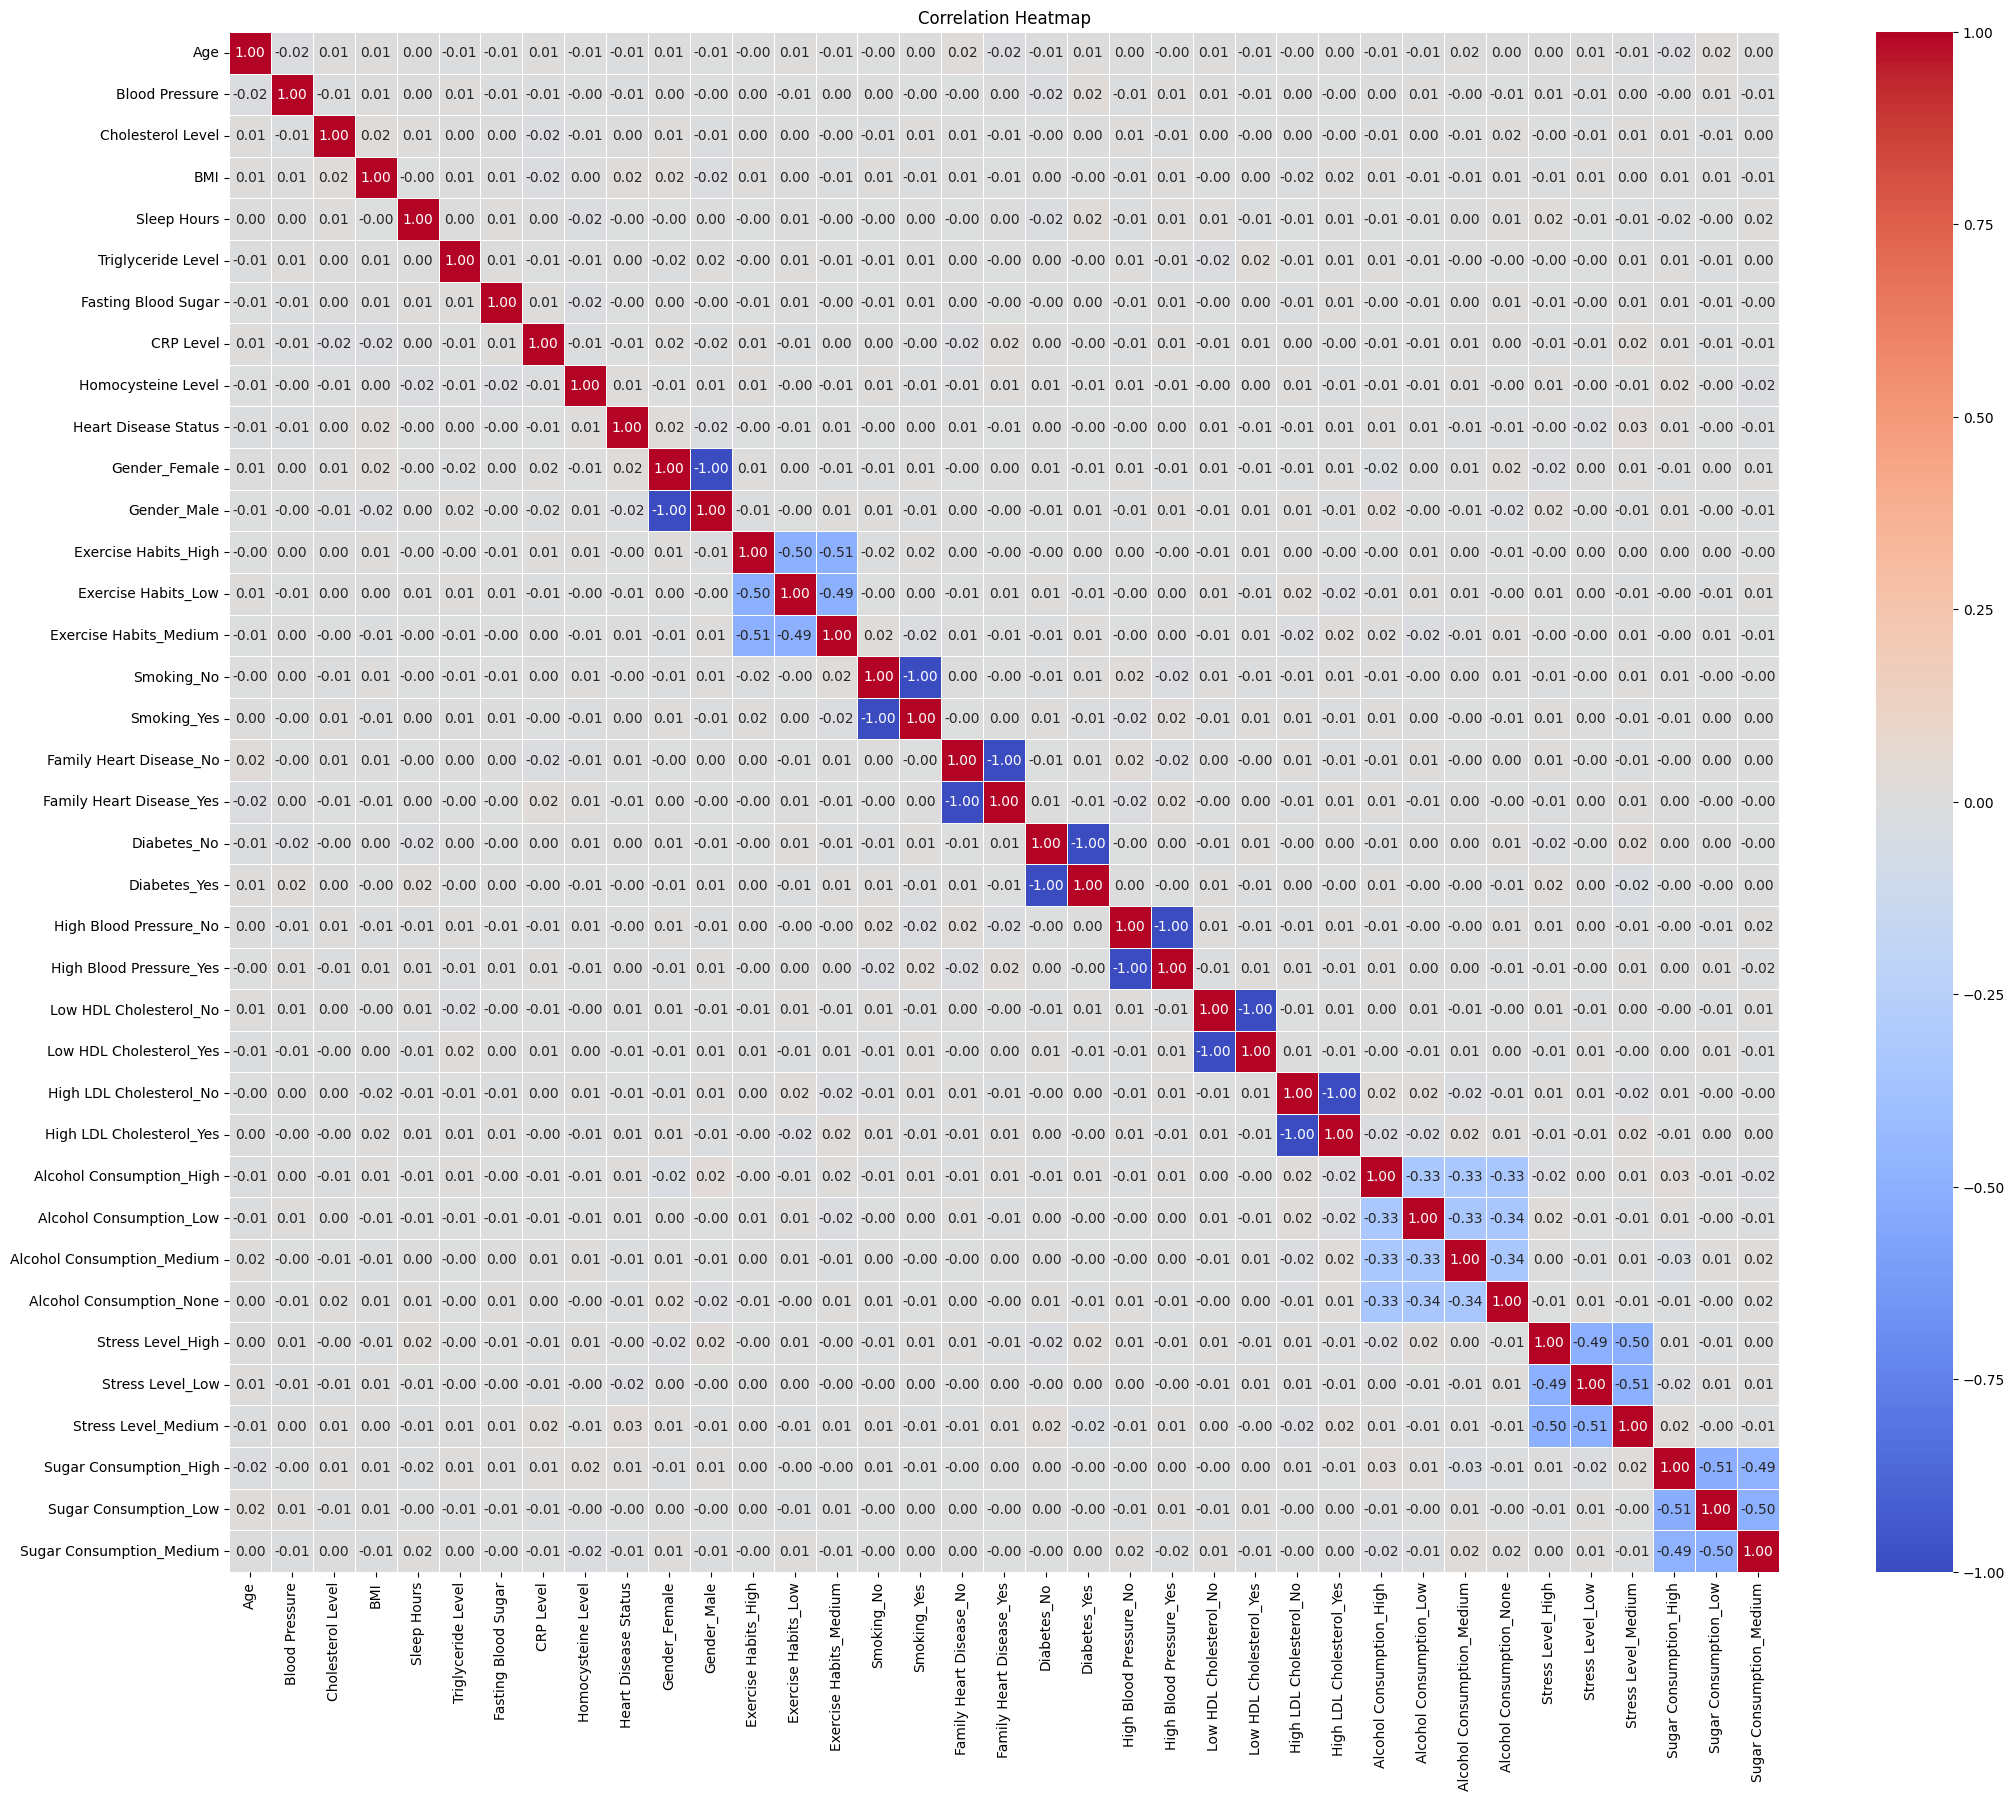

In [50]:
# Correlation for all columns

plt.figure(figsize=(25, 20))

sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Dari semua grafik di atas, didapat bahwa data kategorikal dan numerikal pada dataset ini relatif tidak berkaitan masing-masingnya secara langsung dengan labelnya. Maka dari itu perlu ditinjau korelasi secara inklusif dari semua variabel yang ada terhadap label.

# Prepare for Modelling

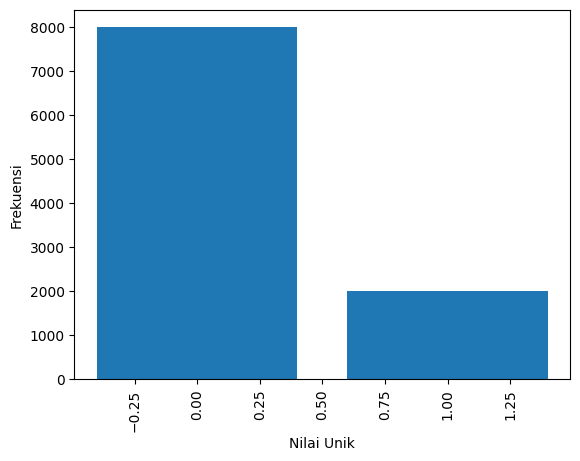

In [51]:
unique_label = df['Heart Disease Status'].value_counts()
plt.bar(unique_label.index, unique_label.values)
plt.xlabel('Nilai Unik')
plt.ylabel('Frekuensi')
plt.xticks(rotation=90)  # Rotasi label jika terlalu banyak
plt.show()

In [52]:
unique_label

,count
Heart Disease Status,
0,8000
1,2000


In [ ]:
# df.to_csv('heart_disease_clean.csv', index=False)
# if you want to download it

In [53]:
X = df.drop('Heart Disease Status', axis=1)
y = df['Heart Disease Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [54]:


# Build Model
model = Sequential([
    Dense(1, activation = 'sigmoid', input_shape=(X_train.shape[1],))
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 1)                   │              37 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1,
)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5128 - loss: 0.8414 - val_accuracy: 0.5258 - val_loss: 0.7664
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5518 - loss: 0.7269 - val_accuracy: 0.5868 - val_loss: 0.6820
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6091 - loss: 0.6603 - val_accuracy: 0.6647 - val_loss: 0.6306
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6878 - loss: 0.6210 - val_accuracy: 0.7553 - val_loss: 0.5983
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7721 - loss: 0.5882 - val_accuracy: 0.7958 - val_loss: 0.5763
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7989 - loss: 0.5672 - val_accuracy: 0.7984 - val_loss: 0.5598
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8089 - loss: 0.5481 - val_accuracy: 0.7984 - val_loss: 0.5475
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7964 - loss: 0.5457 - val_accuracy: 0.

In [ ]:
y_pred = model.predict(X_test)

for i in range(len(y_pred)):
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}") # Use iloc for positional indexing

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Actual: 1, Predicted: [0.19795148]
Actual: 0, Predicted: [0.17054927]
Actual: 0, Predicted: [0.18724859]
Actual: 0, Predicted: [0.2105423]
Actual: 0, Predicted: [0.19063196]
Actual: 1, Predicted: [0.21462467]
Actual: 0, Predicted: [0.23207794]
Actual: 0, Predicted: [0.19002068]
Actual: 0, Predicted: [0.20934185]
Actual: 0, Predicted: [0.19688678]
Actual: 0, Predicted: [0.21841502]
Actual: 0, Predicted: [0.22425658]
Actual: 0, Predicted: [0.20615707]
Actual: 0, Predicted: [0.2174567]
Actual: 0, Predicted: [0.22370699]
Actual: 0, Predicted: [0.19143489]
Actual: 0, Predicted: [0.21388829]
Actual: 0, Predicted: [0.23418634]
Actual: 0, Predicted: [0.1874816]
Actual: 0, Predicted: [0.18657738]
Actual: 0, Predicted: [0.2272449]
Actual: 0, Predicted: [0.1709944]
Actual: 0, Predicted: [0.22595316]
Actual: 0, Predicted: [0.22155844]
Actual: 0, Predicted: [0.22546183]
Actual: 0, Predicted: [0.15349936]
Actual: 0, Predicted: [0.21483207]
Actual: 0, Predicted

# Kesimpulan

1. Value pada masing-masing kolom rleatif tidak berkaitan (berkorelasi) satu sama lain.
2. Terdapat ketidakseimbangan banyak value pada label yang mengakibatkan hasil prediksi cenderung untuk memprediksi 0.
3. Diperlukan dataset yang lebih banyak dan lebih baik, serta diperlukan berbagai teknik yang memungkinkan untuk peningkata performa model seperti oversampling, undersampling, dll.